# Cost-Sensitive Classification under Selective Labels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import causalml as cml

## Multiclass Data Generating Process

- Conditional Prob. of Missingness: $P(D = 1 | X, U, Z) = \text{sigmoid}\Big[ \alpha W_U^{\top} U + (1 - \alpha) \cdot (1 + Z) \cdot W_X^{\top} X \Big]$

- Conditional Prob. of Outcome: 3 classes

    - $P(Y = 1 \mid X, U) = \beta * \text{sigmoid}\Big[ \beta \cdot (-3 U_1) + (1 - \beta) \cdot (3X_1 - X_2) \Big]$

    - $P(Y = 2 \mid X, U) = \text{sigmoid}\Big[ \beta \cdot (-3 U_1) + (1 - \beta) \cdot (3X_1 - X_2) \Big]$

    - $P(Y = 3 \mid X, U) = \text{sigmoid}\Big[ \beta \cdot (-3 U_1) + (1 - \beta) \cdot (3X_1 - X_2) \Big]$


In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

def generate_data(n_samples, n_observed, n_unobserved, num_iv_levels, num_y_classes, confounding_type, confounding_strength_Y, confounding_strength_D, random_seed=100):

    np.random.seed(random_seed)

    # Step 1: Generate observed and unobserved variables X, U
    X = 2 * np.random.normal(size=(n_samples, n_observed))
    U = 2 * np.random.normal(size=(n_samples, n_unobserved))
    
    # Step 2: Generate instrumental variable Z
    Z = np.random.choice(range(1, num_iv_levels + 1), size=n_samples)

    # Step 3: Generate the coefficients of X on Y and U on Y 
    coefficients_X_Y = np.array([[i + j for j in range(num_y_classes)] for i in range(n_observed)])  # Fixed coefficients for Y on X
    coefficients_U_Y = np.array([[i + j for j in range(num_y_classes)] for i in range(n_unobserved)])  # Fixed coefficients for Y on U

    # Step 4: Generate the outcome Y via conditional probabilities 
    linear_combination = (1 - confounding_strength_Y) * X @ coefficients_X_Y + confounding_strength_Y * 2 * (U @ coefficients_U_Y)
    print('linear-combinations', linear_combination)
    probabilities = softmax(linear_combination)
    print('probabilities', probabilities)
    Y = np.array([np.random.choice(range(1, num_y_classes + 1), p=p) for p in probabilities])

    # Step 5: Generate decision D as a function of X, U, and Z
    coefficients_X_D = np.array([2-j for j in range(n_observed)])
    coefficients_U_D = np.array([1+j for j in range(n_unobserved)])
    
    # Step 6: Directly generate probabilities for each action (sigmoid)
    logits_1 = 2 * Z * (X @ coefficients_X_D)
    logits_2 = (U @ coefficients_U_D)
    print(logits_2)
    if confounding_type == 'nucem':
        D_prob = (1 - confounding_strength_D) * sigmoid(logits_1) + confounding_strength_D * sigmoid(logits_2)
    elif confounding_type == 'uc':
        D_prob = sigmoid( (1 - confounding_strength_D) * logits_1 + confounding_strength_D * 3 * logits_2 )
    else:
        raise ValueError("Invalid ztype. Must be 'nucem' or 'uc'.")
    D = np.random.binomial(1, D_prob)

    # Step 7: Aggregate data with augmented variables
    df1 = pd.DataFrame(X, columns=[f'X{i}' for i in range(n_observed)])
    df2 = pd.DataFrame(U, columns=[f'U{i}' for i in range(n_unobserved)])
    data = pd.concat([df1, df2], axis=1).assign(Z=Z, Y=Y, D=D, D_prob=D_prob)

    return data

In [3]:
data_multi = generate_data(n_samples=10000, n_observed=5, n_unobserved=5, num_iv_levels=5, num_y_classes=3,
                           confounding_type='nucem', confounding_strength_Y=0.5, confounding_strength_D=0.7, random_seed=10)
data_multi

linear-combinations [[  1.43723979   6.13993048  10.84262116]
 [ -6.83559699  -6.17494428  -5.51429157]
 [  6.51623237   4.32377217   2.13131197]
 ...
 [-11.89334046 -12.05679541 -12.22025036]
 [-14.64138497 -18.76807049 -22.89475601]
 [ -3.94415369  -4.93747338  -5.93079306]]
probabilities [[8.15338040e-05 8.98856409e-03 9.90929902e-01]
 [1.49602799e-01 2.89639338e-01 5.60757863e-01]
 [8.89596114e-01 9.93160664e-02 1.10878194e-02]
 ...
 [3.89051550e-01 3.30384425e-01 2.80564024e-01]
 [9.83867860e-01 1.58759610e-02 2.56178851e-04]
 [6.63349565e-01 2.45668340e-01 9.09820949e-02]]
[  4.94084243  -5.45569214  -0.87637872 ... -15.4099665  -21.87192141
  -0.38168506]


,X0,X1,X2,X3,X4,U0,U1,U2,U3,U4,Z,Y,D,D_prob
0,2.663173,1.430558,-3.090801,-0.016768,1.242672,1.609454,2.248993,0.149542,-0.483358,0.063641,4,3,1,0.995032
1,-1.440171,0.531023,0.217097,0.008583,-0.349200,2.517096,-0.482604,0.972670,0.774715,-2.604890,2,2,0,0.003370
2,0.866052,2.406075,-1.930131,2.056548,0.457260,-3.524258,-2.307239,-0.085389,1.464097,0.332427,5,1,0,0.505748
3,0.890275,-2.273204,0.270274,2.969074,-2.159610,-3.155841,-1.972770,-0.065583,-2.085800,1.549416,1,1,1,0.254505
4,-3.955457,-3.486745,0.532140,4.769935,2.247383,0.090124,-1.826147,-3.020278,1.733612,0.561744,3,1,0,0.037212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.849325,-1.094029,-0.708934,0.080968,-1.716113,-3.182624,0.849748,-0.187335,2.777043,1.552688,2,3,1,1.000000
9996,-4.178257,-0.041873,-0.333098,-0.354902,0.621496,2.898998,-0.824581,2.397238,-0.290504,-0.126598,2,3,1,0.699092
9997,-1.683834,2.181233,2.599240,2.491315,-2.747054,2.224369,1.237528,-1.226529,-2.666563,-1.152711,4,1,0,0.300000
9998,0.885331,2.189476,0.485741,0.907785,-0.828989,0.073380,-0.517193,-3.370082,0.138357,-2.270819,1,1,0,0.299976


In [4]:
# from scipy.special import expit

# def generate_data_segment(n_samples, n_observed=8, n_unobserved=2, num_iv_levels=5, num_y_classes=3, confounding_type='nucem', confounding_strength_D=0.5, confounding_strength_Y=0.5, random_seed=10):
    
#     np.random.seed(random_seed)
    
#     # Generate observed, unobserved and instrumental variables X, U and Z
#     X = np.random.randn(n_samples, n_observed)
#     U = np.random.randn(n_samples, n_unobserved)
#     Z = np.random.choice(range(1, num_iv_levels + 1), size=n_samples)
    
#     # Generate decision D as a function of X, U, and Z
#     weight_UD = np.random.rand(n_unobserved)
#     weight_XD = np.random.rand(n_observed)
#     bias_D = np.random.rand()

#     if (confounding_type == 'nucem'):
#         ProbD = 1 - (confounding_strength_D * expit(U @ weight_UD) + (1 - confounding_strength_D) * expit((1 + Z) * (X @ weight_XD)) )
#     elif (confounding_type == 'uc'):
#         ProbD = 1 - (expit( confounding_strength_D * 2* (U @ weight_UD) + (1 - confounding_strength_D) * (1 + Z) * (X @ weight_XD)) )
#     else:
#         raise ValueError("Invalid ztype. Must be 'nucem' or 'uc'.")
#     D = np.random.binomial(n=1, p=ProbD, size=n_samples)
    
#     # Generate outcome Y as a function of X, U and Z
#     weight_UY = np.random.uniform(0.5, 1.5, size=n_unobserved) 
#     weight_XY = np.random.uniform(0.5, 1.5, size=n_observed) 
#     scores = confounding_strength_Y * (U @ weight_UY) + (1 - confounding_strength_Y) * (X @ weight_XY)
    
#     # Categorize the scores into multiple categories
#     # thresholds = [np.percentile(scores, 33), np.percentile(scores, 66)]
#     thresholds = [np.percentile(scores, k * 100 / num_y_classes) for k in range(1, num_y_classes)]
#     categories = np.digitize(scores, bins=thresholds, right=True) + 1
    
#     # Aggregate data with augmented variables
#     columns = [f"X{i+1}" for i in range(n_observed)] + [f"U{i+1}" for i in range(n_unobserved)]+['Z','D','Y']
#     data = pd.DataFrame(np.concatenate([X, U, Z.reshape(-1,1), D.reshape(-1, 1), categories.reshape(-1, 1)],axis=1), columns=columns)
    
#     return data

D
0    [[Axes(0.125,0.722857;0.158163x0.157143), Axes...
1    [[Axes(0.125,0.722857;0.158163x0.157143), Axes...
dtype: object

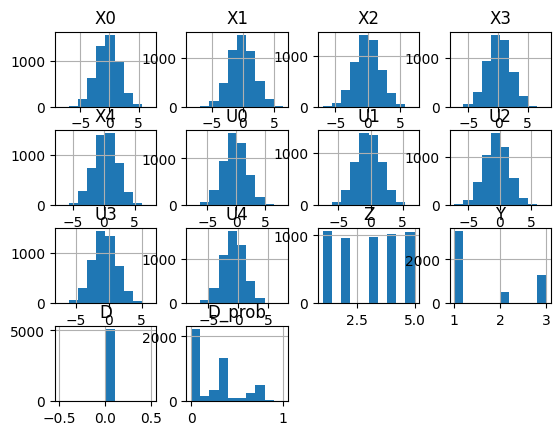

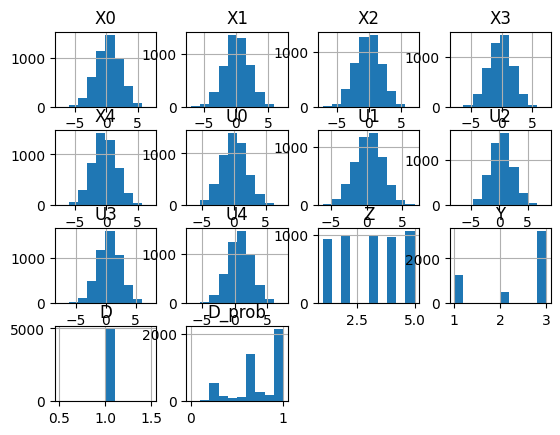

In [5]:
data_multi.groupby(['D']).hist()

In [6]:
# Parameters for learning
parameters = dict()
parameters['outcome'] = 'Y'
parameters['decision'] = 'D'
parameters['instrument'] = 'Z'
parameters['observables'] = data_multi.filter(like='X').columns.tolist()
parameters['unobservables'] = data_multi.filter(like='U').columns.tolist()

parameters

{'outcome': 'Y',
 'decision': 'D',
 'instrument': 'Z',
 'observables': ['X0', 'X1', 'X2', 'X3', 'X4'],
 'unobservables': ['U0', 'U1', 'U2', 'U3', 'U4']}

In [7]:
# Compute the confounding strength

from sklearn.ensemble import HistGradientBoostingClassifier

def unmeasured_confounding(dataset, features, decision, outcome):
    X = dataset[features]
    D = dataset[decision]
    Y = dataset[outcome]
    
    modelD = HistGradientBoostingClassifier(max_iter=200)
    modelY = HistGradientBoostingClassifier(max_iter=200)
    
    modelD.fit(X, D)
    modelY.fit(X, Y)
    
    resD = D - pd.DataFrame(modelD.predict_proba(X) )[1].values
    resY = Y - pd.DataFrame(modelY.predict_proba(X) )[1].values
    
    corr = np.corrcoef(resD, resY)[0, 1]
    
    return corr

# evaluate the strength of unmeasured confounding
unmeasured_confounding(dataset=data_multi, features=parameters['observables'], decision=parameters['decision'], outcome=parameters['outcome'])

np.float64(0.41252951766949547)

In [8]:
parameters

{'outcome': 'Y',
 'decision': 'D',
 'instrument': 'Z',
 'observables': ['X0', 'X1', 'X2', 'X3', 'X4'],
 'unobservables': ['U0', 'U1', 'U2', 'U3', 'U4']}

## Learning with Selective Labels

In [9]:
# acc_multi_selected = cml.Classification(Sample=data_multi, Params=parameters, Selective=True, IPW=False)
# acc_multi_selected_ipw = cml.Classification(Sample=data_multi, Params=parameters, Selective=True, IPW=True)

In [10]:
# Acc_df_multi = pd.DataFrame(index=acc_multi_selected['accuracy'].keys())
# Acc_df_multi['Selective'] = acc_multi_selected['accuracy'].values()
# Acc_df_multi['Selective IPW'] = acc_multi_selected_ipw['accuracy'].values()
# Acc_df_multi

In [11]:
# vanilla
acc_multi_selected= cml.ClassificationNN(Sample=data_multi, Params=parameters, Selective=True, IPW=False)
acc_multi_selected

{'accuracy': 0.537,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

In [12]:
# ipw
acc_multi_selected_ipw = cml.ClassificationNN(Sample=data_multi, Params=parameters, Selective=True, IPW=True)
acc_multi_selected_ipw

{'accuracy': 0.531,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

## Learning with Full Labels

In [14]:
# acc_multi_full = cml.Classification(Sample=data_multi, Params=parameters, Selective=False, IPW=False)

In [15]:
# Acc_df_multi['Full'] = acc_multi_full['accuracy'].values()
# Acc_df_multi

In [13]:
acc_multi_full = cml.ClassificationNN(Sample=data_multi, Params=parameters, Selective=False, IPW=False)
acc_multi_full

{'accuracy': 0.619,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

## Partial Learning (Cost-Sensitive)

In [14]:
partial_weight = cml.CrossFitting(Sample=data_multi, Params=parameters, WeightFunc=cml.IVPartialWeightMulti, noise_level=0.3)
partial_weight

,X0,X1,X2,X3,X4,U0,U1,U2,U3,U4,...,U_3,LR_1,UR_1,LR_2,UR_2,LR_3,UR_3,W_1,W_2,W_3
9,-0.425395,-0.678280,0.624340,1.130305,-0.294841,1.067557,0.462278,-1.412236,1.516166,0.087382,...,1.008227,0.012701,0.484764,0.000543,0.472606,0.514693,0.986757,0.995526,1.007684,0.493533
15,4.935302,-3.016643,1.241201,-2.090265,-1.596018,-0.667915,-2.025034,1.602127,0.170548,0.427521,...,0.541438,0.109763,0.597845,0.026061,0.439396,0.089046,0.541438,0.488082,0.571785,0.508799
18,2.215416,0.489088,-0.123824,-1.507786,1.423918,-1.142876,2.983803,1.844377,-0.986703,0.433432,...,0.948716,0.007852,-0.027777,0.000769,-0.034860,1.027008,0.948716,0.940864,0.947947,0.000000
23,-0.697764,-0.878052,0.282208,0.546099,-3.237141,-0.133719,-0.188992,0.450358,-0.274220,1.992290,...,0.220953,0.694890,0.353807,0.425240,0.084157,0.562036,0.220953,0.067887,0.301241,0.157811
31,0.114570,-1.414143,1.093330,1.885001,-5.959194,-1.794996,2.598512,-2.774214,-1.491259,-1.865707,...,0.680546,0.031734,0.507945,0.019220,0.419324,0.232329,0.680546,0.648813,0.661326,0.448217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9963,-0.105633,-4.629092,0.526947,0.582148,0.872691,-2.074904,-5.755320,0.065733,-1.036179,-2.601255,...,0.517821,0.310505,0.252751,0.229428,0.171674,0.575575,0.517821,0.468393,0.517589,0.076806
9969,-4.901133,2.454161,2.831983,-1.608944,0.515046,-2.451747,0.114265,0.664322,1.261001,-2.811305,...,0.258790,0.145680,-0.013066,0.831779,0.595529,0.266310,0.166705,0.594013,0.000000,0.414242
9972,-0.371166,1.156002,0.381828,2.818567,-3.324469,-0.563554,1.562333,-0.986855,1.019059,3.596909,...,0.231306,0.210534,0.180546,0.641799,0.558160,0.261294,0.231306,0.538478,0.000000,0.432107
9982,-2.139669,-1.254001,0.964775,1.803195,-0.235239,-1.610188,-1.427406,-3.668038,0.029197,1.012035,...,0.614752,0.008244,0.735501,0.000186,0.571114,0.132894,0.614752,0.727257,0.735315,0.602607


In [14]:
acc_multi_partial = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                      Params=parameters, 
                                                      WeightFunc=cml.IVPartialWeightMulti,
                                                      surrogate='exploss', 
                                                      k_folds=5, random_state=100, noise_level=0.0)
acc_multi_partial

{'accuracy': 0.584,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

In [17]:
acc_multi_partial = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                      Params=parameters, 
                                                      WeightFunc=cml.IVPartialWeightMulti,
                                                      surrogate='exploss', 
                                                      k_folds=5, random_state=100, noise_level=1.0)
acc_multi_partial

{'accuracy': 0.574,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

In [18]:
acc_multi_partial = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                      Params=parameters, 
                                                      WeightFunc=cml.IVPartialWeightMulti,
                                                      surrogate='exploss', 
                                                      k_folds=5, random_state=100, noise_level=2.0)
acc_multi_partial

{'accuracy': 0.572,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

In [15]:
acc_multi_partial = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                      Params=parameters, 
                                                      WeightFunc=cml.IVPartialWeightMulti,
                                                      surrogate='exploss', 
                                                      k_folds=5, random_state=100, noise_level=3.0)
acc_multi_partial

{'accuracy': 0.546,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

In [16]:
acc_multi_partial = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                      Params=parameters, 
                                                      WeightFunc=cml.IVPartialWeightMulti,
                                                      surrogate='exploss', 
                                                      k_folds=5, random_state=100, noise_level=4.0)
acc_multi_partial

{'accuracy': 0.305,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

## Point Learning (Cost-sensitive)

In [13]:
point_weight = cml.CrossFitting(Sample=data_multi, Params=parameters, WeightFunc=cml.IVPointWeightMulti, noise_level=0.3)
point_weight

,X0,X1,X2,X3,X4,U0,U1,U2,U3,U4,Z,Y,D,D_prob,W_1,W_2,W_3
9,-0.425395,-0.678280,0.624340,1.130305,-0.294841,1.067557,0.462278,-1.412236,1.516166,0.087382,3,3,0,6.902242e-01,2.508312,2.464635,0.000000
15,4.935302,-3.016643,1.241201,-2.090265,-1.596018,-0.667915,-2.025034,1.602127,0.170548,0.427521,5,1,1,9.637751e-01,0.314460,0.000000,0.027784
18,2.215416,0.489088,-0.123824,-1.507786,1.423918,-1.142876,2.983803,1.844377,-0.986703,0.433432,5,3,1,9.998683e-01,2.120940,2.119777,0.000000
23,-0.697764,-0.878052,0.282208,0.546099,-3.237141,-0.133719,-0.188992,0.450358,-0.274220,1.992290,2,2,1,9.999571e-01,0.027237,0.004103,0.000000
31,0.114570,-1.414143,1.093330,1.885001,-5.959194,-1.794996,2.598512,-2.774214,-1.491259,-1.865707,2,1,1,3.000000e-01,0.235556,0.225665,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9963,-0.105633,-4.629092,0.526947,0.582148,0.872691,-2.074904,-5.755320,0.065733,-1.036179,-2.601255,1,1,0,1.783091e-07,0.134989,0.159511,0.000000
9969,-4.901133,2.454161,2.831983,-1.608944,0.515046,-2.451747,0.114265,0.664322,1.261001,-2.811305,1,1,0,6.815560e-05,0.432497,0.000000,0.187076
9972,-0.371166,1.156002,0.381828,2.818567,-3.324469,-0.563554,1.562333,-0.986855,1.019059,3.596909,3,3,1,1.000000e+00,0.572481,0.000000,0.187076
9982,-2.139669,-1.254001,0.964775,1.803195,-0.235239,-1.610188,-1.427406,-3.668038,0.029197,1.012035,2,1,0,2.372780e-05,0.102864,0.114197,0.000000


In [ ]:
acc_multi_point = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                    Params=parameters, 
                                                    WeightFunc=cml.IVPointWeightMulti, 
                                                    surrogate='exploss',
                                                    k_folds=5, random_state=200, noise_level=0.0)
acc_multi_point

{'accuracy': 0.572,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

In [ ]:
acc_multi_point = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                    Params=parameters, 
                                                    WeightFunc=cml.IVPointWeightMulti, 
                                                    surrogate='exploss',
                                                    k_folds=5, random_state=200, noise_level=1.0)
acc_multi_point

{'accuracy': 0.531,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

In [ ]:
acc_multi_point = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                    Params=parameters, 
                                                    WeightFunc=cml.IVPointWeightMulti, 
                                                    surrogate='exploss',
                                                    k_folds=5, random_state=200, noise_level=2.0)
acc_multi_point

{'accuracy': 0.445,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

In [ ]:
acc_multi_point = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                    Params=parameters, 
                                                    WeightFunc=cml.IVPointWeightMulti, 
                                                    surrogate='exploss',
                                                    k_folds=5, random_state=200, noise_level=3.0)
acc_multi_point

{'accuracy': 0.276,
 'trained_model': SimpleClassifier(
   (fc): Linear(in_features=5, out_features=3, bias=True)
   (relu): ReLU()
 )}

In [ ]:
acc_multi_point = cml.CostSensitiveClassificationNN(Sample=data_multi, 
                                                    Params=parameters, 
                                                    WeightFunc=cml.IVPointWeightMulti, 
                                                    surrogate='exploss',
                                                    k_folds=5, random_state=200, noise_level=3.0)
acc_multi_point

## Summary

In [21]:
acc_dict = dict()
acc_dict['Selective'] = acc_multi_selected['accuracy']
acc_dict['Selective IPW'] = acc_multi_selected_ipw['accuracy']
acc_dict['Full'] = acc_multi_full['accuracy']
acc_dict['Partial'] = acc_multi_partial['accuracy']
acc_dict['Point'] = acc_multi_point['accuracy']

acc_dict

{'Selective': 0.537,
 'Selective IPW': 0.531,
 'Full': 0.619,
 'Partial': 0.584,
 'Point': 0.572}

# Sensitivity Analysis Results

## UC Results

In [17]:
import pickle
import pandas as pd

noise_levels = [7.0, 5.0, 3.0, 0.0]
ACC_UC_Noise = dict()

for noise_level in noise_levels:
    with open(f'Multi-05-24-sensitivity/UC-Accuracy-Iterations-50-Noise-Level-{noise_level}.pickle', 'rb') as handle:
        ACC_UC_Noise[noise_level] = pickle.load(handle)

In [22]:
pd.DataFrame(ACC_UC_Noise[7.0]).mean(), pd.DataFrame(ACC_UC_Noise[7.0]).std()

(Partial Learning    0.53292
 Point Learning      0.43872
 dtype: float64,
 Partial Learning    0.037041
 Point Learning      0.060364
 dtype: float64)

In [23]:
pd.DataFrame(ACC_UC_Noise[5.0]).mean(), pd.DataFrame(ACC_UC_Noise[5.0]).std()

(Partial Learning    0.55864
 Point Learning      0.55890
 dtype: float64,
 Partial Learning    0.030018
 Point Learning      0.023468
 dtype: float64)

In [24]:
pd.DataFrame(ACC_UC_Noise[3.0]).mean(), pd.DataFrame(ACC_UC_Noise[3.0]).std()

(Partial Learning    0.5855
 Point Learning      0.5612
 dtype: float64,
 Partial Learning    0.018805
 Point Learning      0.023220
 dtype: float64)

In [26]:
pd.DataFrame(ACC_UC_Noise[0.0]).mean(), pd.DataFrame(ACC_UC_Noise[0.0]).std()

(Partial Learning    0.6009
 Point Learning      0.5529
 dtype: float64,
 Partial Learning    0.014433
 Point Learning      0.025506
 dtype: float64)

## NUCEM Results ($\alpha_Y = 0.5$, $\alpha_D = 0.7$)

In [1]:
import pickle
import pandas as pd

noise_levels = [7.0, 5.0, 3.0, 0.0]
ACC_NUCEM_Noise = dict()

for noise_level in noise_levels:
    with open(f'Multi-05-24-sensitivity/NUCEM-Accuracy-Iterations-50-Noise-Level-{noise_level}.pickle', 'rb') as handle:
        ACC_NUCEM_Noise[noise_level] = pickle.load(handle)

In [11]:
pd.DataFrame(ACC_NUCEM_Noise[7.0]).mean(), pd.DataFrame(ACC_NUCEM_Noise[7.0]).std()

(Partial Learning    0.54878
 Point Learning      0.53366
 dtype: float64,
 Partial Learning    0.034390
 Point Learning      0.038142
 dtype: float64)

In [12]:
pd.DataFrame(ACC_NUCEM_Noise[5.0]).mean(), pd.DataFrame(ACC_NUCEM_Noise[5.0]).std()

(Partial Learning    0.56374
 Point Learning      0.58574
 dtype: float64,
 Partial Learning    0.027727
 Point Learning      0.021223
 dtype: float64)

In [13]:
pd.DataFrame(ACC_NUCEM_Noise[3.0]).mean(), pd.DataFrame(ACC_NUCEM_Noise[3.0]).std()

(Partial Learning    0.59234
 Point Learning      0.59212
 dtype: float64,
 Partial Learning    0.019633
 Point Learning      0.016187
 dtype: float64)

In [14]:
pd.DataFrame(ACC_NUCEM_Noise[0.0]).mean(), pd.DataFrame(ACC_NUCEM_Noise[0.0]).std()

(Partial Learning    0.60776
 Point Learning      0.60126
 dtype: float64,
 Partial Learning    0.012197
 Point Learning      0.012488
 dtype: float64)

# Repeated Experiment for Multiclass

## UC Results

In [1]:
import pickle
import pandas as pd

confounding_strength_values = [0.3, 0.5, 0.7]
ACC_pickles_uc = dict()

for confounding_strength_Y in confounding_strength_values:
    for confounding_strength_D in confounding_strength_values:
        with open(f'Multi-12-20/UC-Accuracy-Iterations-100-Confounding-Y{confounding_strength_Y}-D{confounding_strength_D}.pickle', 'rb') as handle:
            ACC_pickles_uc[(confounding_strength_Y, confounding_strength_D)] = pickle.load(handle)

In [2]:
pd.DataFrame(ACC_pickles_uc[(0.5, 0.5)])

,Selected Sample,Selected Sample (IPW),Full Sample,Partial Learning,Point Learning
0,0.564,0.557,0.597,0.596,0.518
1,0.575,0.565,0.602,0.597,0.535
2,0.566,0.561,0.602,0.591,0.533
3,0.562,0.551,0.602,0.593,0.524
4,0.560,0.562,0.612,0.593,0.511
...,...,...,...,...,...
95,0.566,0.552,0.601,0.595,0.541
96,0.557,0.552,0.590,0.579,0.519
97,0.585,0.573,0.608,0.606,0.535
98,0.561,0.559,0.615,0.599,0.526


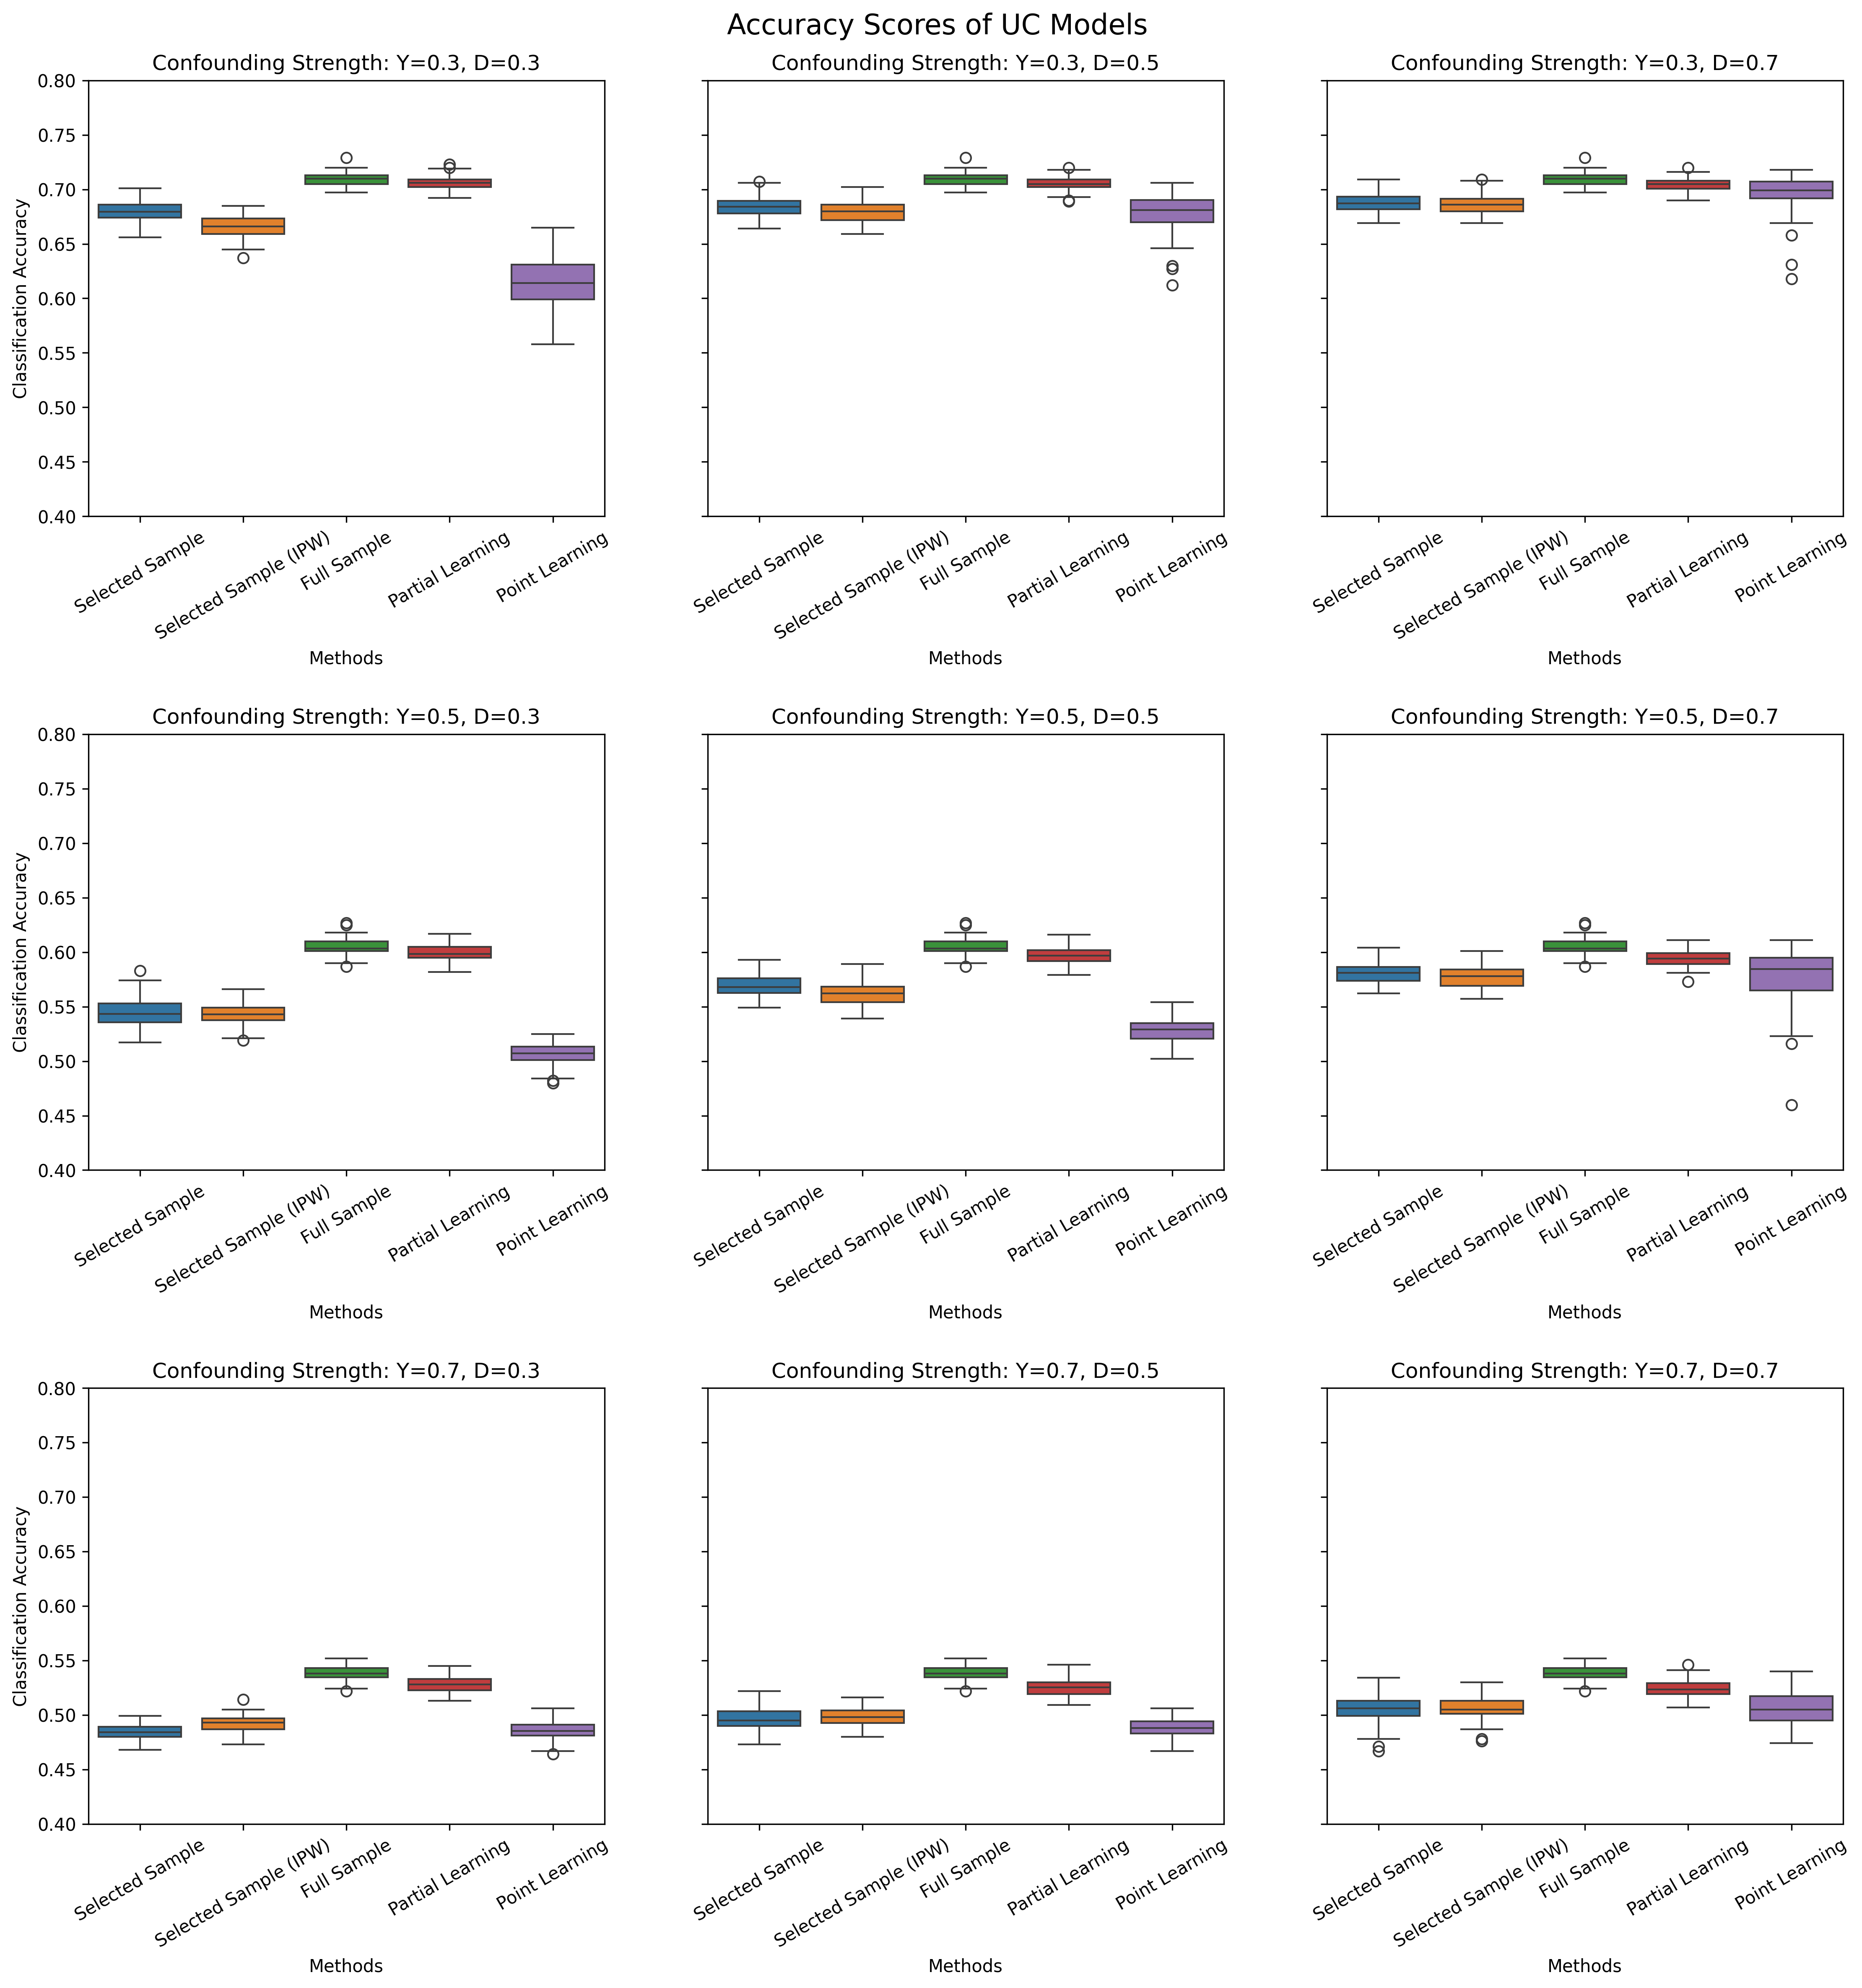

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplots for ACC_pickles_nucem
fig, axes = plt.subplots(nrows=len(confounding_strength_values), ncols=len(confounding_strength_values), sharey=True, figsize=(18, 18), dpi=300)
plt.subplots_adjust(hspace=.5)

for i, conf_strength_Y in enumerate(confounding_strength_values):
    for j, conf_strength_D in enumerate(confounding_strength_values):
        key = (conf_strength_Y, conf_strength_D)
        acc_df = pd.DataFrame(ACC_pickles_uc[key])
        # acc_df = acc_df.drop('Point Learning', axis=1)

        # Boxplot with accuracy scores
        sns.boxplot(ax=axes[i][j], data=acc_df)
        axes[i][j].tick_params(axis='x', rotation=30)
        axes[i][j].set_title(f'Confounding Strength: Y={conf_strength_Y}, D={conf_strength_D}')

        # Set y-axis limits
        axes[i][j].set_xlabel('Methods')
        axes[i][j].set_ylabel('Classification Accuracy')
        axes[i][j].set_ylim(0.4, 0.8)

fig.suptitle('Accuracy Scores of UC Models', x=0.5, y=0.91, fontsize=16)
# plt.savefig('Multi-UC-Accuracy.pdf')
plt.show()

In [4]:
# Mean accuracy of UC model
ACC_mean_uc = pd.DataFrame(columns=ACC_pickles_uc.keys())
for key in ACC_pickles_uc.keys():
    ACC_mean_uc[key] = pd.DataFrame(ACC_pickles_uc[key]).mean()
ACC_mean_uc = ACC_mean_uc.T

ACC_mean_uc

Selected Sample  Selected Sample (IPW)  Full Sample  \
0.3 0.3          0.67990                0.66570      0.70945   
    0.5          0.68428                0.67947      0.70945   
    0.7          0.68749                0.68612      0.70945   
0.5 0.3          0.54434                0.54336      0.60512   
    0.5          0.56905                0.56168      0.60512   
    0.7          0.58048                0.57709      0.60512   
0.7 0.3          0.48461                0.49234      0.53826   
    0.5          0.49632                0.49844      0.53826   
    0.7          0.50600                0.50641      0.53826   

         Partial Learning  Point Learning  
0.3 0.3           0.70575         0.61464  
    0.5           0.70510         0.67864  
    0.7           0.70413         0.69725  
0.5 0.3           0.59960         0.50710  
    0.5           0.59704         0.52812  
    0.7           0.59398         0.57770  
0.7 0.3           0.52819         0.48616  
    0.5           0.52533         0.48855  
    0.7           0.52413         0.50597

In [5]:
# Standard deviation of UC model
ACC_std_uc = pd.DataFrame(columns=ACC_pickles_uc.keys())
for key in ACC_pickles_uc.keys():
    ACC_std_uc[key] = pd.DataFrame(ACC_pickles_uc[key]).std()
ACC_std_uc = ACC_std_uc.T

ACC_std_uc

Selected Sample  Selected Sample (IPW)  Full Sample  \
0.3 0.3         0.009041               0.009849     0.005489   
    0.5         0.008774               0.009247     0.005489   
    0.7         0.008589               0.008587     0.005489   
0.5 0.3         0.012313               0.009403     0.007190   
    0.5         0.010321               0.009891     0.007190   
    0.7         0.009453               0.010136     0.007190   
0.7 0.3         0.006468               0.007368     0.006287   
    0.5         0.011394               0.008702     0.006287   
    0.7         0.011693               0.010454     0.006287   

         Partial Learning  Point Learning  
0.3 0.3          0.005825        0.022676  
    0.5          0.005825        0.017033  
    0.7          0.005949        0.014704  
0.5 0.3          0.007170        0.009194  
    0.5          0.007424        0.011501  
    0.7          0.007282        0.023519  
0.7 0.3          0.007460        0.008015  
    0.5          0.007634        0.008003  
    0.7          0.007514        0.014849

## NUCEM Results

In [10]:
import pickle
import pandas as pd

confounding_strength_values = [0.3, 0.5, 0.7]
ACC_pickles_nucem = dict()

for confounding_strength_Y in confounding_strength_values:
    for confounding_strength_D in confounding_strength_values:
        with open(f'Multi-12-20/NUCEM-Accuracy-Iterations-100-Confounding-Y{confounding_strength_Y}-D{confounding_strength_D}.pickle', 'rb') as handle:
            ACC_pickles_nucem[(confounding_strength_Y, confounding_strength_D)] = pickle.load(handle)

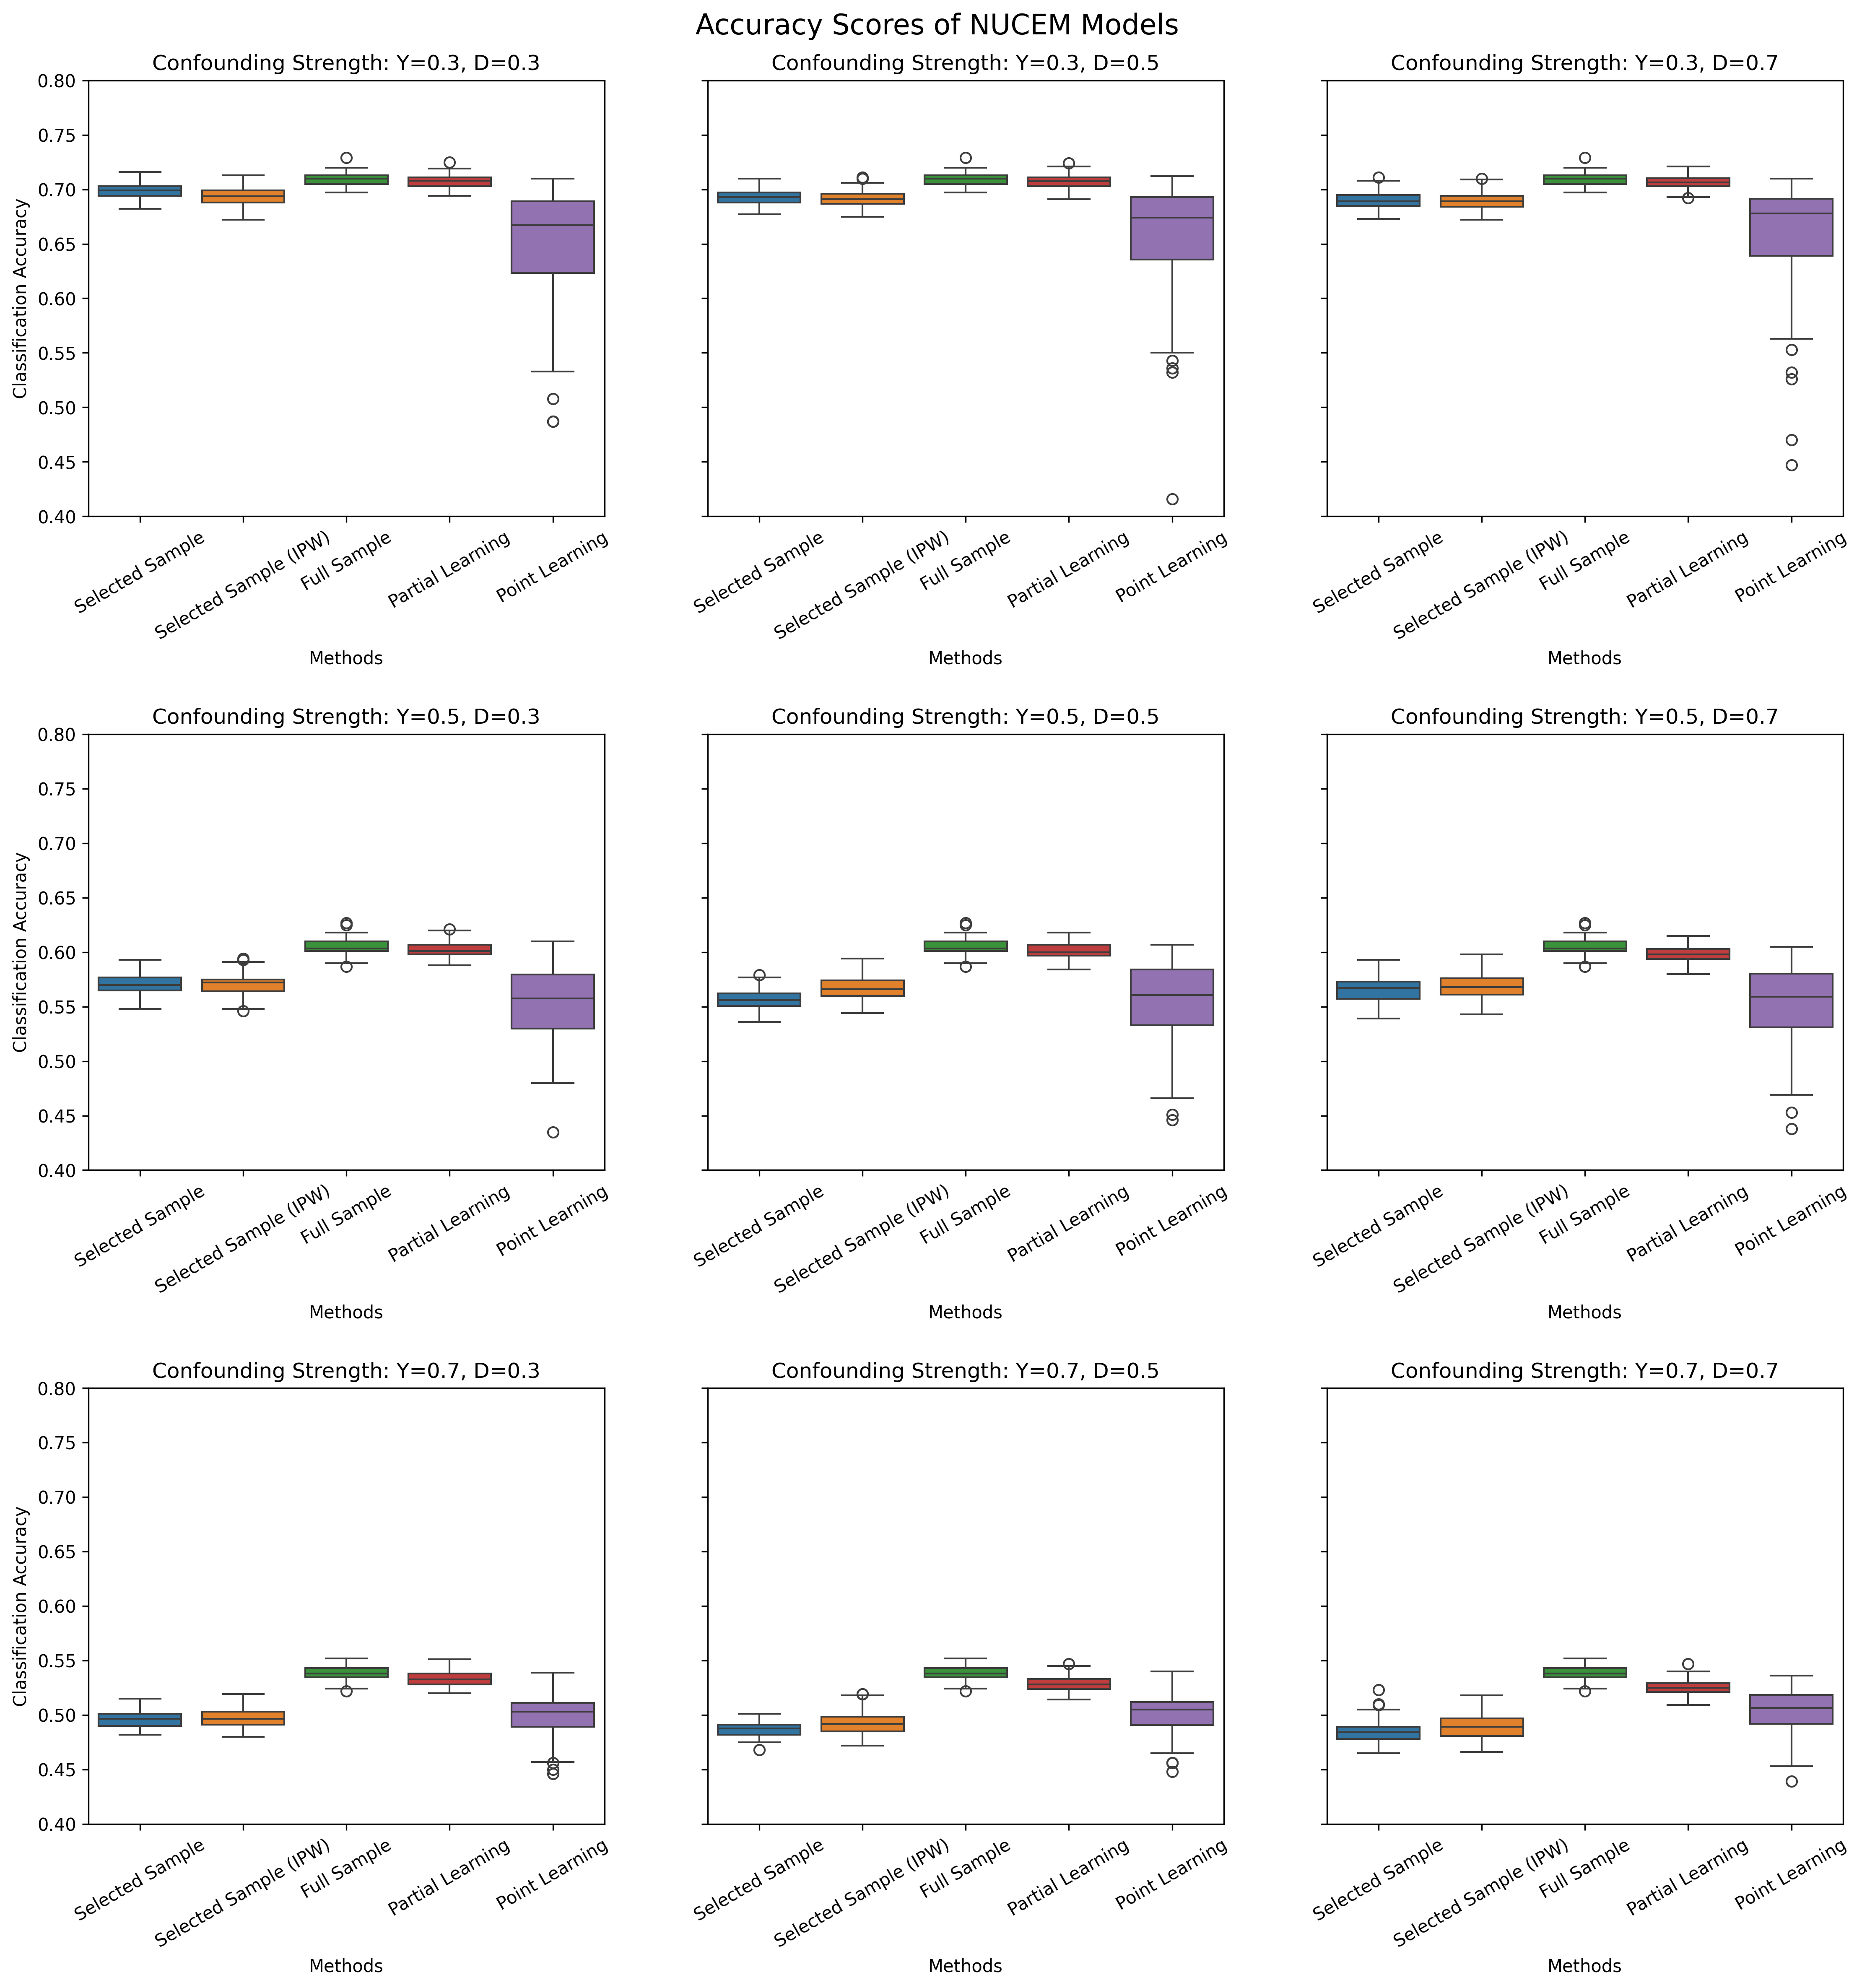

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplots for ACC_pickles_nucem
fig, axes = plt.subplots(nrows=len(confounding_strength_values), ncols=len(confounding_strength_values), sharey=True, figsize=(18, 18), dpi=300)
plt.subplots_adjust(hspace=.5)

for i, conf_strength_Y in enumerate(confounding_strength_values):
    for j, conf_strength_D in enumerate(confounding_strength_values):
        key = (conf_strength_Y, conf_strength_D)
        acc_df = pd.DataFrame(ACC_pickles_nucem[key])

        # Boxplot with accuracy scores
        sns.boxplot(ax=axes[i][j], data=acc_df)
        axes[i][j].tick_params(axis='x', rotation=30)
        axes[i][j].set_title(f'Confounding Strength: Y={conf_strength_Y}, D={conf_strength_D}')

        # Set y-axis limits
        axes[i][j].set_xlabel('Methods')
        axes[i][j].set_ylabel('Classification Accuracy')
        axes[i][j].set_ylim(0.4, 0.8)

fig.suptitle('Accuracy Scores of NUCEM Models', x=0.5, y=0.91, fontsize=16)
# plt.savefig('Multi-NUCEM-Accuracy.pdf')
plt.show()

In [8]:
# Mean accuracy of NUCEM model
ACC_mean_nucem = pd.DataFrame(columns=ACC_pickles_nucem.keys())
for key in ACC_pickles_nucem.keys():
    ACC_mean_nucem[key] = pd.DataFrame(ACC_pickles_nucem[key]).mean()
ACC_mean_nucem = ACC_mean_nucem.T

ACC_mean_nucem

Selected Sample  Selected Sample (IPW)  Full Sample  \
0.3 0.3          0.69842                0.69355      0.70945   
    0.5          0.69291                0.69125      0.70945   
    0.7          0.68984                0.68932      0.70945   
0.5 0.3          0.57032                0.57015      0.60512   
    0.5          0.55680                0.56675      0.60512   
    0.7          0.56539                0.56876      0.60512   
0.7 0.3          0.49623                0.49770      0.53826   
    0.5          0.48689                0.49232      0.53826   
    0.7          0.48426                0.48993      0.53826   

         Partial Learning  Point Learning  
0.3 0.3           0.70730         0.65034  
    0.5           0.70691         0.65821  
    0.7           0.70677         0.65901  
0.5 0.3           0.60287         0.54869  
    0.5           0.60130         0.55187  
    0.7           0.59790         0.55009  
0.7 0.3           0.53304         0.49921  
    0.5           0.52846         0.49881  
    0.7           0.52544         0.50119

In [9]:
# Standard deviation of NUCEM model
ACC_std_nucem = pd.DataFrame(columns=ACC_pickles_nucem.keys())
for key in ACC_pickles_nucem.keys():
    ACC_std_nucem[key] = pd.DataFrame(ACC_pickles_nucem[key]).std()
ACC_std_nucem = ACC_std_nucem.T

ACC_std_nucem

Selected Sample  Selected Sample (IPW)  Full Sample  \
0.3 0.3         0.006643               0.007174     0.005489   
    0.5         0.006895               0.007404     0.005489   
    0.7         0.007535               0.007712     0.005489   
0.5 0.3         0.008208               0.010116     0.007190   
    0.5         0.009700               0.010945     0.007190   
    0.7         0.011672               0.011067     0.007190   
0.7 0.3         0.007109               0.008553     0.006287   
    0.5         0.006797               0.009657     0.006287   
    0.7         0.009778               0.012234     0.006287   

         Partial Learning  Point Learning  
0.3 0.3          0.005730        0.052129  
    0.5          0.006117        0.049916  
    0.7          0.005841        0.049734  
0.5 0.3          0.007095        0.040071  
    0.5          0.007143        0.039596  
    0.7          0.007115        0.042280  
0.7 0.3          0.006809        0.017170  
    0.5          0.007474        0.028484  
    0.7          0.007241        0.027496